# Test notebook for Acceptance Test Campaign related to LSST Science Pipelines Release 19.0.0

This test will be executed on the LSST Science Platform Notebook Aspect, initialized with Science Pipelines release `r19-0-0`.

### Test case LVV-T62: Verify implementation of Provide PSF for Coadded Images
Verify that all coadd images produced by the DRP pipelines include a model from which an image of the PSF at any point on the coadd can be obtained.

In [1]:
# Confirm that the version of the Science Pipelines is v19_0_0:
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-jcarlin-r19-0-0
lsst_distrib          19.0.0+2   	current v19_0_0 setup


In [2]:
import lsst.daf.persistence as dafPersist
import lsst.geom as geom
from lsst.afw.image import Exposure, Image, PARENT

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import random

from astropy.visualization import (MinMaxInterval, AsinhStretch, ZScaleInterval, LogStretch, LinearStretch,
                                   ImageNormalize)

In [4]:
# Set plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
zscale = ZScaleInterval()

# Set up some plotting defaults:
plt.rcParams.update({'figure.figsize' : (12, 8)})
plt.rcParams.update({'font.size' : 10})
plt.rcParams.update({'axes.linewidth' : 3})
plt.rcParams.update({'axes.labelweight' : 3})
plt.rcParams.update({'axes.titleweight' : 3})
plt.rcParams.update({'ytick.major.width' : 3})
plt.rcParams.update({'ytick.minor.width' : 2})
plt.rcParams.update({'ytick.major.size' : 8})
plt.rcParams.update({'ytick.minor.size' : 5})
plt.rcParams.update({'xtick.major.size' : 8})
plt.rcParams.update({'xtick.minor.size' : 5})
plt.rcParams.update({'xtick.major.width' : 3})
plt.rcParams.update({'xtick.minor.width' : 2})
plt.rcParams.update({'xtick.direction' : 'in'})
plt.rcParams.update({'ytick.direction' : 'in'})

We will use HSC-RC2, as processed using `w_2019_46`, which is the pipelines version that was used to create `v19_0_0`.

In [5]:
# The output repo is tagged with the Jira ticket number "DM-22223":

rc2_repo = '/datasets/hsc/repo/rerun/RC/w_2019_46/DM-22223'

In [6]:
# Initialize the butler repo:
butler = dafPersist.Butler(rc2_repo)

# Make a glob of the files in the repo, so we can parse this to get tract/patch IDs:
infiles = glob.glob(rc2_repo+'/deepCoadd-results/HSC-*/*/*/calexp-*.fits')
print(len(infiles))

1198


#### Make arrays of the tract, patch numbers by parsing the filenames¶

In [7]:
tract_array = []
patch_array = []

# Each line of "infiles" looks like this (infile[0]):
# '/datasets/hsc/repo/rerun/RC/w_2019_46/DM-22223/deepCoadd-results/HSC-R/9615/8,8/calexp-HSC-R-9615-8,8.fits'

# Split on the '/', then parse the resulting array. Here's the result of infiles[0].split('/'):

#['',
# 'datasets',
# 'hsc',
# 'repo',
# 'rerun',
# 'RC',
# 'w_2019_46',
# 'DM-22223',
# 'deepCoadd',
# 'HSC-R',
# '9615',
# '8,8',
# 'warp-HSC-R-9615-8,8-23902.fits']

# So the tract number is third from the end, and patch is second from the end.

for ii in range(0, len(infiles)):
    parts = infiles[ii].split('/')
    tract_array.append(int(parts[-3]))
    patch_array.append(parts[-2])

print('Found %i patches'%(len(patch_array)))
    
# Assemble in pandas data frame    
data = {'tract': tract_array,
        'patch': patch_array}
df_tract_patch = pd.DataFrame(data=data)

Found 1198 patches


In [8]:
# df_tract_patch

In [9]:
# Check the tract names that are available:
print('The repo contains the following tracts: ',df_tract_patch.tract.unique())

The repo contains the following tracts:  [9615 9813 9697]


In [10]:
# Select some tract/patch combinations from these at random:
numpatches = 6 # 12
patch_sel = df_tract_patch.sample(numpatches)

In [11]:
patch_sel

,tract,patch
911,9697,"1,1"
961,9615,"0,4"
564,9813,"5,2"
1030,9615,"4,0"
256,9615,"0,5"
374,9813,"1,7"


In [12]:
## CCDs number from 0-111. Randomly select a CCD for each of the visits:
#ccdnums = np.random.randint(112, size=numpatches)
#
## CCD 9 is bad, so generate a new array until we have no "9" values in it:
#exclude_ccds = [9]
#while ccdnums.any() in exclude_ccds:
#    ccdnums = np.random.randint(112, size=numvisits)

In [13]:
#calexps = [] ### The calexps are too big, causing the kernel to run out of memory and die. :(
datarefs = []

for row, pch in patch_sel.iterrows():
    # print(vis)
    # Note: we are using only the 'HSC-R' filter for this, but other filters could be selected:
    dataref = {'tract':int(pch.tract), 'patch':pch.patch, 'filter':'HSC-R'}
    # Sometimes CCDs fail, so test whether the dataset exists before grabbing it:
    if butler.datasetExists('deepCoadd_calexp', dataId = dataref):
#        calexp = butler.get('deepCoadd_calexp', dataId = dataref)
#        calexps.append(calexp)
        datarefs.append(dataref)
    else:
        print('dataref: '+str(dataref)+' does not exist. Skipping.')


In [14]:
# datarefs

Note that a simple way to confirm that a given `calexp` image has a PSF is via the method: `calexp.hasPsf()`.

#### For each of the selected tract/patch combinations, pick a random (X,Y) coordinate, extract the PSF, and plot an image of the PSF.

No images at the requested point.


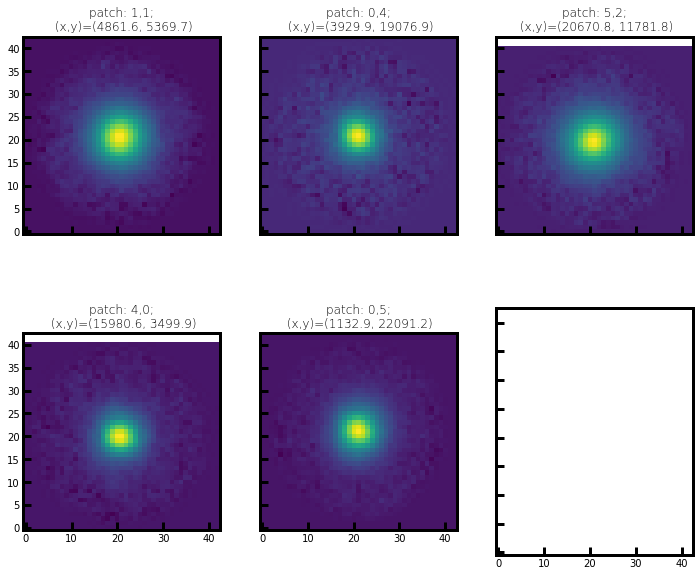

In [15]:
ncols = 3 # 4
nrows = numpatches/ncols # 4 plots per row
f, ax = plt.subplots(nrows=int(np.ceil(nrows)), ncols=int(ncols), sharey=True, sharex=True, figsize=(12,10))
axnum = 0
axs = ax.flatten()

for dataref in datarefs:
#    print(c.hasPsf())
    c = butler.get('deepCoadd_calexp', dataId = dataref)
    psf = c.getPsf()
    xsize = c.getDimensions().getX()
    ysize = c.getDimensions().getY()
    x0 = c.getX0()
    y0 = c.getY0()

    # Select a random point on the image and extract the PSF at that point:
    xpt = x0+random.random()*xsize
    ypt = y0+random.random()*ysize

    noimg_flag = False
    try:
        psfimage = psf.computeImage(geom.PointD(xpt, ypt))
    except:
        print('No images at the requested point.')
        noimg_flag = True
        
    if not noimg_flag:
        
        img = psfimage.array

        # Create an ImageNormalize object
        norm = ImageNormalize(img, interval=MinMaxInterval(),
                              stretch=LogStretch())

#    axs[axnum].set_xlim(psfimage.getX0(),psfimage.getX0()+psfimage.getDimensions()[0])
#    axs[axnum].set_ylim(psfimage.getY0(),psfimage.getY0()+psfimage.getDimensions()[1])
        axs[axnum].set_title('patch: '+patch_sel.iloc[axnum].patch+';\n (x,y)=('+str(round(xpt,1))+', '+str(round(ypt,1))+')')
        axs[axnum].imshow(img, norm=norm, origin='lower')

    axnum += 1


### Now confirm that the PSF is reasonably well-matched to stellar images by selecting a bright star in each image and subtracting the PSF at the star's position:

In [16]:
# Pick a bright star that was used to fit the PSF, and one that was used to calibrate the photometry:
src = butler.get('deepCoadd_forced_src', dataId=dataref)
ref = butler.get('deepCoadd_ref', dataId=dataref)

is_primary = (ref['detect_isPrimary'] == True) & (np.isfinite(src.getPsfInstFlux()))
deblended = (src["deblend_nChild"] == 0)
ptsource = (src['base_ClassificationExtendedness_flag'] == False)

# Make a copy of the star selection that is contiguous in memory:
stars = src[is_primary & deblended & ptsource].copy(deep=True)
stars_flux = stars.getPsfInstFlux()

# Pick stars between the 85th and 90th percentiles in PSF flux:
p85 = np.percentile(stars_flux, 85)
p90 = np.percentile(stars_flux, 90)
keepers = (stars_flux > p85) & (stars_flux < p90)


In [17]:
star_sel = random.choice(stars[keepers])
radec_star_sel = star_sel.getCoord()

In [18]:
wcs = c.getWcs()

cutoutSize = geom.ExtentI(100, 100) # size of cutout in pixels
xy = geom.Point2I(wcs.skyToPixel(radec_star_sel)) # central XY coordinate of our star's RA, Dec position

# Create the bounding box:
bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)

# Full patch image
#image = butler.get('calexp', immediate=True, dataId=dataid)
# Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
xy0 = c.getXY0() 

# Postage stamp image only, using the bbox defined above:
cutout_image = butler.get('deepCoadd_calexp_sub', bbox=bbox, immediate=True, dataId=dataref).getMaskedImage()
# Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
xy0_cutout = cutout_image.getXY0() 

In [19]:
psf = c.getPsf()
model = Exposure(cutout_image.getBBox(), dtype=np.float32)
model.setPsf(psf)
psfImage = psf.computeImage(star_sel.getCentroid())
flux = star_sel['base_PsfFlux_instFlux']-(star_sel['base_PsfFlux_area']*star_sel['base_LocalBackground_instFlux'])
psfBBox = psfImage.getBBox()
model.image[psfBBox, PARENT].scaledPlus(flux, psfImage.convertF())
residuals = cutout_image.clone()
residuals.image -= model.image

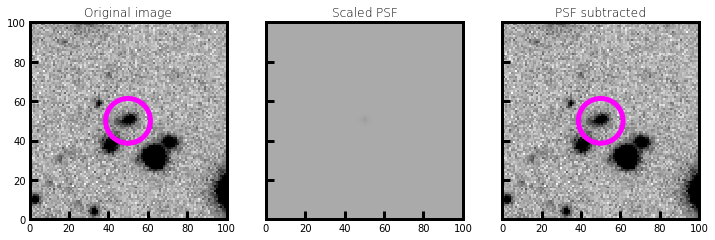

In [20]:
f, ax = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True, figsize=(12,6))
axs = ax.flatten()

vmin0, vmax0 = zscale.get_limits(cutout_image.image.array)
# Get the dimensions of the image so we can set plot limits
imsize = cutout_image.getDimensions()
axs[0].imshow(cutout_image.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
# Set the plot range to the dimensions:
axs[0].set_xlim(0,imsize[0])
axs[0].set_ylim(0,imsize[1])
axs[0].set_title('Original image')
axs[0].scatter(xy.getX()-xy0_cutout.getX(), xy.getY()-xy0_cutout.getY(), color='none', edgecolor='magenta', s=2000, linewidth=5)

# Get the dimensions of the image so we can set plot limits
imsize = model.image.getDimensions()
axs[1].imshow(model.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
# Set the plot range to the dimensions:
axs[1].set_xlim(0,imsize[0])
axs[1].set_ylim(0,imsize[1])
axs[1].set_title('Scaled PSF')

# Get the dimensions of the image so we can set plot limits
imsize = residuals.image.getDimensions()
axs[2].imshow(residuals.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
# Set the plot range to the dimensions:
axs[2].set_xlim(0,imsize[0])
axs[2].set_ylim(0,imsize[1])
axs[2].set_title('PSF subtracted')
axs[2].scatter(xy.getX()-xy0_cutout.getX(), xy.getY()-xy0_cutout.getY(), color='none', edgecolor='magenta', s=2000, linewidth=5)



### Check the images of some bright stars, and see how well the PSF matches the stellar image:
For the images selected at random, pick (again, at random) a bright star and look at (a) its image, (b) an image of the scaled PSF at its position, and (c) the residuals after subtracting the scaled PSF from the original image.

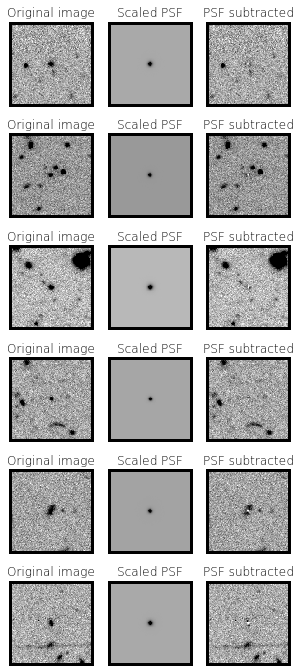

In [21]:
ncols = 3
nrows = numpatches # a star from each patch per row
f, ax = plt.subplots(nrows=int(nrows), ncols=int(ncols), sharey=True, sharex=True, figsize=(5,12))
axnum = 0
axs = ax.flatten()
plt.rcParams.update({'font.size' : 10})

for dataref in datarefs:
#    print(c.hasPsf())
    c = butler.get('deepCoadd_calexp', dataId = dataref)

    # Load the source catalog:
    src = butler.get('deepCoadd_forced_src', dataId=dataref)
    ref = butler.get('deepCoadd_ref', dataId=dataref)

    is_primary = (ref['detect_isPrimary'] == True) & (np.isfinite(src.getPsfInstFlux()))
    deblended = (src["deblend_nChild"] == 0)
    ptsource = (src['base_ClassificationExtendedness_flag'] == False)

    # Make a copy of the star selection that is contiguous in memory:
    stars = src[is_primary & deblended & ptsource].copy(deep=True)
    stars_flux = stars.getPsfInstFlux()

    # Pick stars between the 85th and 90th percentiles in PSF flux:
    p85 = np.percentile(stars_flux, 85)
    p90 = np.percentile(stars_flux, 90)
    keepers = (stars_flux > p85) & (stars_flux < p90)

    wcs = c.getWcs()
    # Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
    xy0 = c.getXY0() 

    # size of image cutout in pixels
    imsize = 100
    cutoutSize = geom.ExtentI(imsize, imsize)
    
    calexp_dimen = c.getDimensions()

#    # Pick one from the table at random, but require it to have coordinates
#    #   such that the bounding box will not extend beyond the CCD's border:
#    oksrc = False
#    while not oksrc:
#        star_sel = random.choice(stars[keepers])
#        xy = star_sel.getCentroid()
#        xpos = xy.getX()-xy0.getX()
#        ypos = xy.getY()-xy0.getY()
#        if (xpos > imsize/2.0) and (xpos < calexp_dimen[0]-imsize/2.0) and (ypos > imsize/2.0) and (ypos < calexp_dimen[1]-imsize/2.0):
#            oksrc = True

#    # star_sel = random.choice(stars[keepers])
#    radec_star_sel = star_sel.getCoord()

    # It's possible that this will pick a star with bounding box extending beyond the image. That's what the loop while loop above is
    #    intended for. But it seemed to take forever, so something's clearly wrong...
    star_sel = random.choice(stars[keepers])
    xy = star_sel.getCentroid()

    # Create the bounding box:
    xy = geom.Point2I(xy)
    bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)

    # Postage stamp image only, using the bbox defined above:
    cutout_image = butler.get('deepCoadd_calexp_sub', bbox=bbox, immediate=True, dataId=dataref).getMaskedImage()
    # Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
    xy0_cutout = cutout_image.getXY0() 

    psf = c.getPsf()
    model = Exposure(cutout_image.getBBox(), dtype=np.float32)
    model.setPsf(psf)
    psfImage = psf.computeImage(star_sel.getCentroid())
    flux = star_sel['base_PsfFlux_instFlux']-(star_sel['base_PsfFlux_area']*star_sel['base_LocalBackground_instFlux'])
    psfBBox = psfImage.getBBox()
    model.image[psfBBox, PARENT].scaledPlus(flux, psfImage.convertF())
    residuals = cutout_image.clone()
    residuals.image -= model.image

    vmin0, vmax0 = zscale.get_limits(cutout_image.image.array)
    # Get the dimensions of the image so we can set plot limits
    imsize = cutout_image.getDimensions()
    axs[axnum].imshow(cutout_image.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
    # Set the plot range to the dimensions:
    axs[axnum].set_xlim(0,imsize[0])
    axs[axnum].set_ylim(0,imsize[1])
    axs[axnum].set_title('Original image')
    axs[axnum].get_xaxis().set_visible(False)
    axs[axnum].get_yaxis().set_visible(False)

    axnum += 1

    # Get the dimensions of the image so we can set plot limits
    imsize = model.image.getDimensions()
    axs[axnum].imshow(model.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
    # Set the plot range to the dimensions:
    axs[axnum].set_xlim(0,imsize[0])
    axs[axnum].set_ylim(0,imsize[1])
    axs[axnum].set_title('Scaled PSF')
    axs[axnum].get_xaxis().set_visible(False)
    axs[axnum].get_yaxis().set_visible(False)
    
    axnum += 1

    # Get the dimensions of the image so we can set plot limits
    imsize = residuals.image.getDimensions()
    axs[axnum].imshow(residuals.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
    # Set the plot range to the dimensions:
    axs[axnum].set_xlim(0,imsize[0])
    axs[axnum].set_ylim(0,imsize[1])
    axs[axnum].set_title('PSF subtracted')
    axs[axnum].get_xaxis().set_visible(False)
    axs[axnum].get_yaxis().set_visible(False)

    axnum += 1



### Use the "hasPsf" method to check whether a larger number of the patch images have an associated PSF model:
(Note: we use only a randomly-selected subset of images because it takes too long to extract the calexp for all images in the repository.)

In [22]:
# Select some tract/patch combinations from the repo at random:
numpatches_boolcheck = 100
patch_sel_boolcheck = df_tract_patch.sample(numpatches_boolcheck)

In [23]:
datarefs_boolcheck = []
psfflags = []

for row, pch in patch_sel_boolcheck.iterrows():
    # print(vis)
    # Note: we are using only the 'HSC-R' filter for this, but other filters could be selected:
    dataref = {'tract':int(pch.tract), 'patch':pch.patch, 'filter':'HSC-R'}
    # Sometimes CCDs fail, so test whether the dataset exists before grabbing it:
    if butler.datasetExists('deepCoadd_calexp', dataId = dataref):
        calexp = butler.get('deepCoadd_calexp', dataId = dataref)
        psfflags.append(calexp.hasPsf())
        datarefs.append(dataref)


### Confirm that _all_ images that we checked have an associated PSF model:

In [24]:
assert(np.all(psfflags)), 'FALSE: not all patches have an associated PSF model.'
print('All patches have an associated PSF model: ',np.all(psfflags))

All patches have an associated PSF model:  True
